In [ ]:
import matplotlib.pyplot as plt
plt.style.use('seaborn-dark')
import numpy as np
%matplotlib inline
import matplotlib
matplotlib.rcParams['figure.figsize'] = 16, 8
import warnings
warnings.simplefilter('ignore')
import gym
import time
from IPython.display import clear_output
import itertools

# Lab 2: Final

Curso Aprendizaje por Refuerzos, Diplomatura en Ciencia de Datos, Aprendizaje Automático y sus Aplicaciones

FaMAF, 2018

## Introducción

En el siguiente notebook se muestra cómo ejecutar agentes de aprendizaje por refuerzos que hacen uso de modelos matematicos para aproximar una funcion de valor.

Ventajas:
* Permite trabajar con grandes espacios de estados al hacer uso de generalización.
* Permite trabajar con espacio de estados continuos.

Problemas:
* Aproximación de objetivos no estacionarios (nononstationarity reward) y con retardo (delayed reward).
* Bootstrapping

## CartPole: Agente aleatorio

In [2]:
env = gym.make('CartPole-v0')
env.reset()
for _ in range(250):
    env.render(mode='human')
    observation, reward, done, info = env.step(env.action_space.sample()) # se ejecuta una acción aleatoria
    if done:
        env.reset()
env.close()
clear_output()

## CartPole: Aproximación con un modelo lineal
A continuación analizaremos la implementacion de un agente Q-Learning que utiliza como aproximador de la función de valor, un modelo lineal.

Hay un gran problema con el uso de aproximadores para la funcion de valor $Q$. Las transiciones están muy correlacionadas. Esto reduce la varianza general de cada transición. Ya que toda la experiencia es extraida del mismo episodio (del actual). 

Imaginemos que tuvieramos que aprender una tarea sin memoria (ni siquiera a corto plazo), siempre optimizaría el aprendizaje en función del último episodio.

El equipo de investigación de Google DeepMind utilizó lo que llamaron 'Experience Replay' para minimizar este problema. Esto es, en lugar de actualizar la función de valor con la última transición realizada, se almacena la misma en memoria y despues de cada interacción del agente con el entorno, se entrena la función de valor con un lote de transiciones muestreadas al azar de la memoria de experiencia.

In [3]:
from agents.cart_pole_approx_vf import CartPole_SGD

agent = CartPole_SGD.SGDCartPoleSolver()
scores_SGD = agent.run()

[2018-09-24 14:33:59,101] Making new env: CartPole-v0


[Episode 0] - Mean survival time over last 100 episodes was 13.0 ticks.
[Episode 100] - Mean survival time over last 100 episodes was 22.33 ticks.
[Episode 200] - Mean survival time over last 100 episodes was 17.65 ticks.
[Episode 300] - Mean survival time over last 100 episodes was 14.6 ticks.
[Episode 400] - Mean survival time over last 100 episodes was 14.62 ticks.
[Episode 500] - Mean survival time over last 100 episodes was 12.4 ticks.
[Episode 600] - Mean survival time over last 100 episodes was 13.2 ticks.
[Episode 700] - Mean survival time over last 100 episodes was 12.74 ticks.
[Episode 800] - Mean survival time over last 100 episodes was 13.59 ticks.
[Episode 900] - Mean survival time over last 100 episodes was 12.29 ticks.
[Episode 999] - Mean survival time over last 100 episodes was 12.63 ticks.


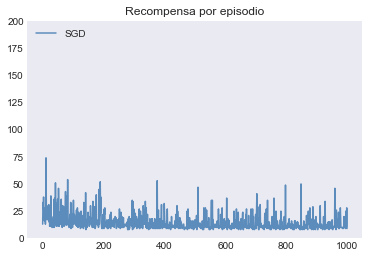

In [20]:
# se muestra el reward/score optenido por episodio
plt.plot(np.array(range(0, len(scores_SGD))), np.array(scores_SGD), label='SGD', c='#5c8cbc')
plt.ylim(0, 200)
plt.title('Recompensa por episodio')
plt.legend(loc='upper left')
plt.show()

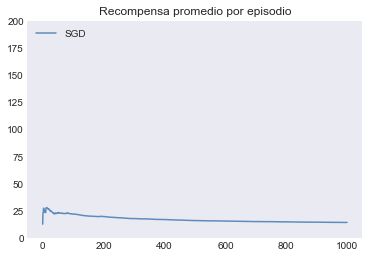

In [21]:
# se suaviza la curva de convergencia
def avg_reward(scores):
    episode_number = np.linspace(1, len(scores) + 1, len(scores) + 1)
    acumulated_rewards = np.cumsum(scores)
    return [acumulated_rewards[i] / episode_number[i] for i in range(len(acumulated_rewards))]

reward_per_episode_SGD = avg_reward(scores_SGD)

plt.plot(reward_per_episode_SGD, label='SGD', c='#5c8cbc')
plt.ylim(0, 200)
plt.title('Recompensa promedio por episodio')
plt.legend(loc='upper left')
plt.show()

## CartPole: Aproximación con un modelo lineal con 'feature construction'
Supongamos que un problema de aprendizaje por refuerzo que tiene estados con dos dimensiones númericas. Para un estado $s$, sus dos componentes son $s_1 \in R$ y $s_2 \in R$. Se puede elegir representar $s$ simplemente por las dos dimensiones del estado, de modo que $x(s)=(s_1, s_2)$, pero así, no se puede tener en cuenta ninguna interacción entre estas dimensiones. Además, si tanto $s_1$ como $s_2$ son cero, entonces el valor aproximado también será cero ($x(s)=0$). Ambas limitaciones se pueden superar representando $s$ por el vector de features polinomico $x(s)=(1,s_1,s_2,s_1s_2)$. El 1 inicial, permite la representación de funciones afines en los números de estado originales, y el feature del producto final, $s1s2$, permite que se tengan en cuenta dichas interacciones. Tambien se puede utilizar un vector de features polinomico de mayor orden, como $x(s)=(1,s_1,s_2,s_1s_2,s_1^2,s_2^2,s_1s_2^2,s_1^2s_2,s_1^2s_2^2)$, para poder modelar interacciónes mas complejas.

In [6]:
from agents.cart_pole_approx_vf import CartPole_SGD_Poly

agent = CartPole_SGD_Poly.SGDPolyCartPoleSolver()
scores_SGD_Poly = agent.run()

[2018-09-24 14:34:41,049] Making new env: CartPole-v0


[Episode 0] - Mean survival time over last 100 episodes was 17.0 ticks.
[Episode 100] - Mean survival time over last 100 episodes was 21.49 ticks.
[Episode 200] - Mean survival time over last 100 episodes was 24.56 ticks.
[Episode 300] - Mean survival time over last 100 episodes was 22.08 ticks.
[Episode 400] - Mean survival time over last 100 episodes was 18.7 ticks.
[Episode 500] - Mean survival time over last 100 episodes was 22.32 ticks.
[Episode 600] - Mean survival time over last 100 episodes was 22.04 ticks.
[Episode 700] - Mean survival time over last 100 episodes was 27.73 ticks.
[Episode 800] - Mean survival time over last 100 episodes was 31.08 ticks.
[Episode 900] - Mean survival time over last 100 episodes was 55.2 ticks.
[Episode 999] - Mean survival time over last 100 episodes was 46.76 ticks.


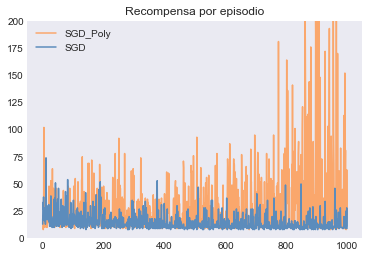

In [22]:
# se muestra el reward/score optenido por episodio
plt.plot(np.array(range(0, len(scores_SGD_Poly))), np.array(scores_SGD_Poly), label='SGD_Poly', c='#faa76c')
plt.plot(np.array(range(0, len(scores_SGD))), np.array(scores_SGD), label='SGD', c='#5c8cbc')
plt.ylim(0, 200)
plt.title('Recompensa por episodio')
plt.legend(loc='upper left')
plt.show()

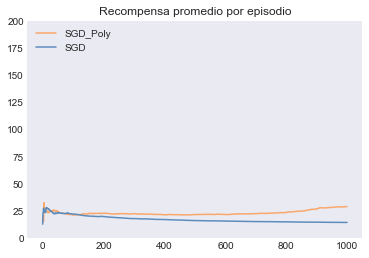

In [23]:
reward_per_episode_SGD_Poly = avg_reward(scores_SGD_Poly)

plt.plot(reward_per_episode_SGD_Poly, label='SGD_Poly', c='#faa76c')
plt.plot(reward_per_episode_SGD, label='SGD', c='#5c8cbc')
plt.ylim(0, 200)
plt.title('Recompensa promedio por episodio')
plt.legend(loc='upper left')
plt.show()

## CartPole: Aproximación con un modelo lineal y 'Modelo Duplicado'
El objetivo para una actualización de un algoritmo de control basado en TD, depende de la estimación de la función de valor de la acción actual. Donde el objetivo (target), es una función dependiente de los mismos parámetros que se están actualizando. Por ejemplo:

$$w_{t+1}=w_t+\alpha[R_{t+1}+\gamma \operatorname*{max}_a\hat{q}(S_{t+1},a,w_t)-\hat{q}(S_t,A_t,w_t)]\nabla\hat{q}(S_t,A_t,w_t)$$

Esta dependencia de $w_t$ complica el proceso en comparación con la situación más simple de aprendizaje supervisado en la que los objetivos no dependen de los parámetros que se actualizan. Esto puede conducir a oscilaciones y/o divergencia.

Para abordar este problema, el equipo de Google DeepMind desarrollo una solucion para acercar el proceso de actualización de los parametros ($w_t$) de un estimador, al caso mas simple utilizado en aprendizaje supervisado. Esto es, cada vez que se realizan un cierto número, $C$, de actualizaciones de los pesos $w$ en el predictor, se realiza una copia de los mismos en en otro predictor (Predictor Secundario), donde se mantienen estos pesos duplicados fijados para las próximas $C$ actualizaciones de $w$. Las estimaciones de este predictor duplicado, se utilizan como objetivo en la actualizacion de los pesos $w$, en las próximas $C$ actualizaciones:

$$w_{t+1}=w_t+\alpha[R_{t+1}+\gamma \operatorname*{max}_a\underline{\tilde{q}(S_{t+1},a,w_t)}-\hat{q}(S_t,A_t,w_t)]\nabla\hat{q}(S_t,A_t,w_t)$$

In [9]:
from agents.cart_pole_approx_vf import CartPole_SGD_Poly_Dual

agent = CartPole_SGD_Poly_Dual.SGDPolyDualCartPoleSolver()
scores_SGD_Poly_Dual = agent.run()

[2018-09-24 14:43:20,010] Making new env: CartPole-v0


[Episode 0] - Mean survival time over last 100 episodes was 30.0 ticks.
[Episode 100] - Mean survival time over last 100 episodes was 25.4 ticks.
[Episode 200] - Mean survival time over last 100 episodes was 25.36 ticks.
[Episode 300] - Mean survival time over last 100 episodes was 29.58 ticks.
[Episode 400] - Mean survival time over last 100 episodes was 39.92 ticks.
[Episode 500] - Mean survival time over last 100 episodes was 55.29 ticks.
[Episode 600] - Mean survival time over last 100 episodes was 71.69 ticks.
[Episode 700] - Mean survival time over last 100 episodes was 73.37 ticks.
[Episode 800] - Mean survival time over last 100 episodes was 77.46 ticks.
[Episode 900] - Mean survival time over last 100 episodes was 76.16 ticks.
[Episode 999] - Mean survival time over last 100 episodes was 107.15 ticks.


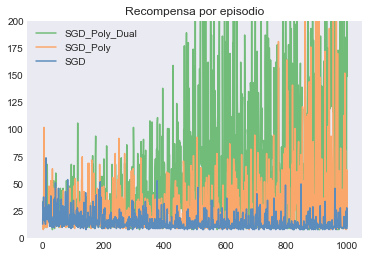

In [24]:
# se muestra el reward/score optenido por episodio
plt.plot(np.array(range(0, len(scores_SGD_Poly_Dual))), np.array(scores_SGD_Poly_Dual), label='SGD_Poly_Dual', c='#71bc78')
plt.plot(np.array(range(0, len(scores_SGD_Poly))), np.array(scores_SGD_Poly), label='SGD_Poly', c='#faa76c')
plt.plot(np.array(range(0, len(scores_SGD))), np.array(scores_SGD), label='SGD', c='#5c8cbc')
plt.ylim(0, 200)
plt.title('Recompensa por episodio')
plt.legend(loc='upper left')
plt.show()

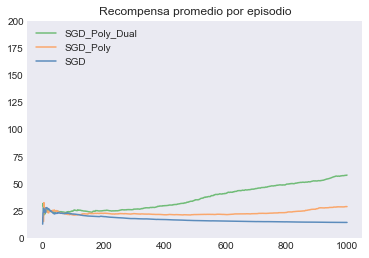

In [25]:
reward_per_episode_SGD_Poly_Dual = avg_reward(scores_SGD_Poly_Dual)
plt.plot(reward_per_episode_SGD_Poly_Dual, label='SGD_Poly_Dual', c='#71bc78')
plt.plot(reward_per_episode_SGD_Poly, label='SGD_Poly', c='#faa76c')
plt.plot(reward_per_episode_SGD, label='SGD', c='#5c8cbc')
plt.ylim(0, 200)
plt.title('Recompensa promedio por episodio')
plt.legend(loc='upper left')
plt.show()

## CartPole: Aproximación con Redes Neuronales

In [26]:
from agents.cart_pole_approx_vf import CartPole_DQN

agent = CartPole_DQN.DQNCartPoleSolver()
scores_DQN = agent.run()

[2018-09-24 15:54:30,927] Making new env: CartPole-v0


[Episode 0] - Mean survival time over last 100 episodes was 39.0 ticks.
[Episode 100] - Mean survival time over last 100 episodes was 29.22 ticks.


KeyboardInterrupt: 

In [ ]:
# se muestra el reward/score optenido por episodio
plt.plot(np.array(range(0, len(scores_DQN))), np.array(scores_DQN), label='DQN', c='#7e5fa4')
plt.plot(np.array(range(0, len(scores_SGD_Poly_Dual))), np.array(scores_SGD_Poly_Dual), label='SGD_Poly_Dual', c='#71bc78')
plt.plot(np.array(range(0, len(scores_SGD_Poly))), np.array(scores_SGD_Poly), label='SGD_Poly', c='#faa76c')
plt.plot(np.array(range(0, len(scores_SGD))), np.array(scores_SGD), label='SGD', c='#5c8cbc')
plt.ylim(0, 200)
plt.title('Recompensa por episodio')
plt.legend(loc='upper left')
plt.show()

In [ ]:
reward_per_episode_DQN = avg_reward(scores)
plt.plot(reward_per_episode_DQN, label='DQN', c='#7e5fa4')
plt.plot(reward_per_episode_SGD_Poly_Dual, label='SGD_Poly_Dual', c='#71bc78')
plt.plot(reward_per_episode_SGD_Poly, label='SGD_Poly', c='#faa76c')
plt.plot(reward_per_episode_SGD, label='SGD', c='#5c8cbc')
plt.ylim(0, 200)
plt.title('Recompensa promedio por episodio')
plt.legend(loc='upper left')
plt.show()